In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import probplot
from IPython.display import Markdown, display


K_BOLTZ_eV = 8.617333262e-5  # eV/K


class Fit_ADT_sqrt_Arrhenius:
    """
    Fit a sqrt-time + Arrhenius degradation model to ADT data.

        D(t, T) = g0 + g1 * sqrt(t) * exp(Ea / k * (1/T_use - 1/T))

    Parameters
    ----------
    degradation : array-like
        Observed degradation values D_ij.
    stress : array-like
        Temperature in degrees Celsius for each observation.
    time : array-like
        Time in the same units used in the model (e.g. hours).
    stress_use : float
        Use temperature in degrees Celsius.
    CI : float, default 0.95
        Confidence level for parameter intervals and noise bands.
    method : {"LS", "MLE", "MLE_hierarchical", "Bayesian"}, default "MLE"
        Fitting approach.
    noise : {"additive", "multiplicative"}, default "additive"
        Stochastic error model for MLE/Bayesian fits.
    show_data_plot : bool, default False
        If True, plot raw degradation vs time, coloured by temperature.
    show_LSQ_diagnostics : bool, default False
        If True and method=="LS" (or for LS pre-fit in MLE), show residual diagnostics.
    show_noise_bounds : bool, default True
        If True and method=="MLE", plot mean curve with noise bands.
    print_results : bool, default True
        If True, print parameter estimates and (approximate) CIs.
    **kwargs :
        Reserved for future extensions (e.g., optimizer options).
    """

    def __init__(
        self,
        degradation,
        stress,
        time,
        unit,
        stress_use,
        CI=0.95,
        method="MLE",
        noise="additive",
        show_data_plot=False,
        show_LSQ_diagnostics=False,
        show_noise_bounds=True,
        print_results=True,
        **kwargs,
    ):
        # --- Basic data housekeeping ---
        self.D = np.asarray(degradation, dtype=float).ravel()
        self.T_C = np.asarray(stress, dtype=float).ravel()
        self.t = np.asarray(time, dtype=float).ravel()
        self.unit = np.asarray(unit, int).ravel()
        if not (self.unit.shape == self.D.shape == self.T_C.shape == self.t.shape):
            raise ValueError("unit, degradation, stress, and time must all match in shape.")

        self.unique_units, self.unit_index = np.unique(self.unit, return_inverse=True)
        self.J = len(self.unique_units)
        self.T_K = self.T_C + 273.15
        self.T_use_C = float(stress_use)
        self.T_use_K = self.T_use_C + 273.15

        self.CI = CI
        self.alpha = 1.0 - CI
        self.z_CI = norm.ppf(0.5 + CI / 2.0)
        self.method = method
        self.noise = noise.lower()
        self.show_data_plot = show_data_plot
        self.show_LSQ_diagnostics = show_LSQ_diagnostics
        self.show_noise_bounds = show_noise_bounds
        self.print_results = print_results
        self.kwargs = kwargs

        # Storage for parameter estimates
        self.theta_LS = None        # (g0, g1, Ea)
        self.sigma_LS = None        # residual std from LS
        self.cov_LS = None

        self.theta_MLE = None       # (g0, g1, Ea)
        self.sigma_MLE = None
        self.cov_MLE = None

        # --- Optional raw data plot ---
        if self.show_data_plot:
            self._plot_data()

        # --- Fit according to chosen method ---
        method_norm = method.lower()
        if method_norm == "ls":
            self._fit_LS(suppress_print=False)
            if self.show_LSQ_diagnostics:
                self._plot_LS_diagnostics()
            self._plot_fit_LS()

        elif method_norm == "mle":
            # Use LS as initialisation, but don't print LS table
            self._fit_LS(suppress_print=True)
            if self.show_LSQ_diagnostics:
                self._plot_LS_diagnostics()
            self._fit_MLE()
            self._plot_fit_MLE()

        elif method_norm in ("mle_hierarchical", "mle_heirachical"):
            self._fit_LS(suppress_print=True)
            if self.show_LSQ_diagnostics:
                self._plot_LS_diagnostics()
            self._fit_MLE_hierarchical()
            self._plot_fit_MLE_hierarchical()

        elif method_norm in ("bayesian", "bayesianl"):
            self._fit_LS(suppress_print=True)
            if self.show_LSQ_diagnostics:
                self._plot_LS_diagnostics()
            self._fit_Bayesian()
        else:
            raise ValueError(f"Unknown method: {method}")

    # ------------------------------------------------------------------
    # Model helpers
    # ------------------------------------------------------------------

    @staticmethod
    def _accel_factor_from_params(T_use_K, T_K, Ea):
        return np.exp(Ea / K_BOLTZ_eV * (1.0 / T_use_K - 1.0 / T_K))

    @staticmethod
    def _mu_D(theta, t, T_K, T_use_K):
        g0, g1, Ea = theta
        accel = Fit_ADT_sqrt_Arrhenius._accel_factor_from_params(T_use_K, T_K, Ea)
        return g0 + g1 * np.sqrt(t) * accel

    # ------------------------------------------------------------------
    # LS fit
    # ------------------------------------------------------------------
    def _init_guess(self):
        # Rough-and-ready initial guesses
        g0_init = float(np.percentile(self.D, 10))
        span = max(np.percentile(self.D, 90) - g0_init, 1e-6)
        g1_init = span / max(np.sqrt(self.t.max()), 1.0)
        Ea_init = 0.7  # eV, generic-ish starter
        return np.array([g0_init, g1_init, Ea_init])

    def _ls_objective(self, theta):
        mu = self._mu_D(theta, self.t, self.T_K, self.T_use_K)
        resid = self.D - mu
        return np.sum(resid ** 2)

    def _fit_LS(self, suppress_print=False):
        theta0 = self._init_guess()

        bounds = [
            (None, None),   # g0
            (1e-10, None),  # g1 > 0
            (1e-3, 5.0),    # Ea in [0.001, 5] eV
        ]

        res = minimize(
            self._ls_objective,
            theta0,
            method="L-BFGS-B",
            bounds=bounds,
        )

        if not res.success:
            print("Warning: LS fit did not converge:", res.message)

        self.theta_LS = res.x
        mu = self._mu_D(self.theta_LS, self.t, self.T_K, self.T_use_K)
        resid = self.D - mu
        dof = max(len(self.D) - len(self.theta_LS), 1)
        self.sigma_LS = np.sqrt(np.sum(resid ** 2) / dof)

        # Approximate covariance from inverse Hessian
        hess_inv = getattr(res, "hess_inv", None)
        if hasattr(hess_inv, "todense"):
            self.cov_LS = np.array(hess_inv.todense())
        elif isinstance(hess_inv, np.ndarray) and hess_inv.ndim == 2:
            self.cov_LS = hess_inv
        else:
            self.cov_LS = None

        # Only print if not being used as a silent initializer
        if self.print_results and not suppress_print:
            self._print_param_table(
                self.theta_LS,
                self.cov_LS,
                sigma=self.sigma_LS,
                label="LSQ"
            )

    # ------------------------------------------------------------------
    # MLE fit
    # ------------------------------------------------------------------
    def _negloglik_additive(self, params):
        g0, g1, Ea, log_sigma = params
        sigma = np.exp(log_sigma)

        theta = np.array([g0, g1, Ea])
        mu = self._mu_D(theta, self.t, self.T_K, self.T_use_K)

        # Guardrails
        if sigma <= 0 or not np.all(np.isfinite(mu)):
            return np.inf

        return -np.sum(norm.logpdf(self.D, loc=mu, scale=sigma))

    def _negloglik_multiplicative(self, params):
        g0, g1, Ea, log_sigma = params
        sigma = np.exp(log_sigma)
        theta = np.array([g0, g1, Ea])

        mu = self._mu_D(theta, self.t, self.T_K, self.T_use_K)
        # Need positive mean and observed values for lognormal error
        D_pos = np.clip(self.D, 1e-12, None)
        mu_pos = np.clip(mu, 1e-12, None)

        logD = np.log(D_pos)
        logmu = np.log(mu_pos)

        if sigma <= 0 or not np.all(np.isfinite(logmu)):
            return np.inf

        return -np.sum(norm.logpdf(logD, loc=logmu, scale=sigma))

    def _fit_MLE(self):
        if self.theta_LS is None:
            raise RuntimeError("LS fit must be performed before MLE.")

        g0_LS, g1_LS, Ea_LS = self.theta_LS
        sigma0 = self.sigma_LS if self.sigma_LS is not None else np.std(self.D)
        params0 = np.array([g0_LS, g1_LS, Ea_LS, np.log(sigma0 + 1e-6)])

        if self.noise == "additive":
            fun = self._negloglik_additive
        elif self.noise == "multiplicative":
            fun = self._negloglik_multiplicative
        else:
            raise ValueError("noise must be 'additive' or 'multiplicative'.")

        bounds = [
            (None, None),   # g0
            (1e-10, None),  # g1
            (1e-3, 5.0),    # Ea
            (np.log(1e-6), np.log(1e3)),  # log_sigma
        ]

        res = minimize(
            fun,
            params0,
            method="L-BFGS-B",
            bounds=bounds,
        )

        if not res.success:
            print("Warning: MLE fit did not converge:", res.message)

        g0, g1, Ea, log_sigma = res.x
        self.theta_MLE = np.array([g0, g1, Ea])
        self.sigma_MLE = float(np.exp(log_sigma))

        # Approximate covariance
        hess_inv = getattr(res, "hess_inv", None)
        if hasattr(hess_inv, "todense"):
            self.cov_MLE = np.array(hess_inv.todense())
        elif isinstance(hess_inv, np.ndarray) and hess_inv.ndim == 2:
            self.cov_MLE = hess_inv
        else:
            self.cov_MLE = None

        if self.print_results:
            self._print_param_table(
                self.theta_MLE,
                self.cov_MLE,
                sigma=self.sigma_MLE,
                label=f"MLE ({self.noise})"
            )

    # ------------------------------------------------------------------
    # Hierarchical MLE
    # ------------------------------------------------------------------
    def _fit_MLE_hierarchical(self):
        """
        Hierarchical MLE using internal log-joint model.

        Uses:
        - self._hier_init_theta0() for initial theta (unless hier_theta0 provided in kwargs)
        - self._neg_log_joint_hier() as objective
        - self._unpack_theta_hier() to store structured results

        NOTE: This is currently implemented for multiplicative/lognormal noise.
        """
        # Optionally allow override of theta0 via kwargs
        theta0 = self.kwargs.get("hier_theta0", None)
        if theta0 is None:
            theta0 = self._hier_init_theta0()

        res = minimize(
            self._neg_log_joint_hier,
            np.asarray(theta0, float),
            method="L-BFGS-B",
        )

        if not res.success:
            print("Warning: hierarchical MLE did not converge:", res.message)

        self.theta_hier = res.x
        self.res_hier = res

        (self.mu_g0_mle, self.sig_g0_mle,
         self.mu_g1_mle, self.sig_g1_mle,
         self.mu_Ea_mle, self.sig_Ea_mle,
         self.sigma_y_hier_mle,
         self.gamma0_j_mle,
         self.gamma1_j_mle,
         self.Ea_j_mle) = self._unpack_theta_hier(self.theta_hier)

        if self.print_results:
            from IPython.display import Markdown, display

            # Extract population parameters
            mu_g0  = self.mu_g0_mle
            sig_g0 = self.sig_g0_mle

            mu_g1  = self.mu_g1_mle
            sig_g1 = self.sig_g1_mle

            mu_Ea  = self.mu_Ea_mle
            sig_Ea = self.sig_Ea_mle

            sigma_y = self.sigma_y_hier_mle

            # Compute CI bounds: mean ± z * std
            CI_pct = int(self.CI * 100)

            def ci(mu, sd):
                lo = mu - self.z_CI * sd
                hi = mu + self.z_CI * sd
                return f"[{lo:.3g}, {hi:.3g}]"

            lines = []
            lines.append(f"### Hierarchical MLE Population Parameters ({CI_pct}% CI)\n")
            lines.append(f"| Parameter | Mean Estimate | STD | {CI_pct}% CI |")
            lines.append(f"|-----------|----------------|------|----------------|")
            lines.append(f"| $\gamma_0$ | {mu_g0:.6g} | {sig_g0:.6g} | {ci(mu_g0, sig_g0)} |")
            lines.append(f"| $\gamma_1$ | {mu_g1:.6g} | {sig_g1:.6g} | {ci(mu_g1, sig_g1)} |")
            lines.append(f"| $E_a$ (eV) | {mu_Ea:.6g} | {sig_Ea:.6g} | {ci(mu_Ea, sig_Ea)} |")
            lines.append(f"| $\\sigma_y$ (log D) | {sigma_y:.6g} | N/A | {ci(sigma_y, sigma_y)} |")

            display(Markdown("\n".join(lines)))


    def _unpack_theta_hier(self, theta):
        """
        theta = [mu_g0, log_sig_g0,
                 mu_g1, log_sig_g1,
                 mu_Ea, log_sig_Ea,
                 log_sigma_obs,
                 gamma0_0..J-1, gamma1_0..J-1, Ea_0..J-1]
        """
        J = self.J
        idx = 0
        mu_g0, log_sig_g0 = theta[idx], theta[idx+1]; idx += 2
        mu_g1, log_sig_g1 = theta[idx], theta[idx+1]; idx += 2
        mu_Ea, log_sig_Ea = theta[idx], theta[idx+1]; idx += 2
        log_sigma_obs     = theta[idx];               idx += 1
    
        gamma0_j = theta[idx       : idx+J]; idx += J
        gamma1_j = theta[idx       : idx+J]; idx += J
        Ea_j     = theta[idx       : idx+J]; idx += J
    
        sig_g0  = np.exp(log_sig_g0)
        sig_g1  = np.exp(log_sig_g1)
        sig_Ea  = np.exp(log_sig_Ea)
        sigma_y = np.exp(log_sigma_obs)
    
        return (mu_g0, sig_g0, mu_g1, sig_g1, mu_Ea, sig_Ea,
                sigma_y,
                gamma0_j, gamma1_j, Ea_j)
    
    def _mu_D_unit(self, theta_j, t, T_K):
        """
        Use the main class degradation model for unit-level parameters.
        """
        return Fit_ADT_sqrt_Arrhenius._mu_D(
            theta_j,     # (gamma0_j, gamma1_j, Ea_j)
            t,
            T_K,
            self.T_use_K
        )

    def _log_likelihood_lognormal(self, D_vec, mu_vec, sigma):
        """
        Log-likelihood for lognormal observation error:
            ln(y) = ln(D) + eps, eps ~ N(0, sigma^2)
    
        p(y|D,sigma) = 1/(y*sigma) * phi((ln(y)-ln(D))/sigma)
        """
        if sigma <= 0:
            return -np.inf
        if np.any(D_vec <= 0) or np.any(mu_vec <= 0):
            return -np.inf
    
        z = (np.log(D_vec) - np.log(mu_vec)) / sigma
        return (
            -np.sum(np.log(D_vec))        # Jacobian term
            - len(mu_vec) * np.log(sigma) # scale
            + np.sum(norm.logpdf(z))      # standard normal density
        )

    def _log_joint_hier(self, theta):
        """
        Joint log-likelihood for:
        - Data given per-unit parameters and observation noise (lognormal error)
        - Per-unit parameters given population means/SDs (random-effects layer)
        """
        J = self.J
        j_idx = self.unit_index
        t_vec = self.t
        T_vec = self.T_K
        D_vec = self.D
    
        (mu_g0, sig_g0, mu_g1, sig_g1, mu_Ea, sig_Ea,
         sigma_y,
         gamma0_j, gamma1_j, Ea_j) = self._unpack_theta_hier(theta)
    
        # Guard rails on SDs and physically-meaningful ranges
        if (sig_g0 <= 0) or (sig_g1 <= 0) or (sig_Ea <= 0) or (sigma_y <= 0):
            return -np.inf
        if np.any(gamma1_j <= 0) or np.any(Ea_j <= 0) or np.any(gamma0_j < 0):
            return -np.inf
    
        # --- Likelihood: lognormal errors on D ---
        mu_vec = np.empty_like(D_vec, dtype=float)
        for j in range(J):
            m = (j_idx == j)
            if not np.any(m):
                continue
            mu_vec[m] = self._mu_D_unit(
                (gamma0_j[j], gamma1_j[j], Ea_j[j]),
                t_vec[m],
                T_vec[m],
            )
    
        if not np.all(np.isfinite(mu_vec)):
            return -np.inf
    
        ll_data = self._log_likelihood_lognormal(D_vec, mu_vec, sigma_y)
    
        # --- Random-effects layer: per-unit parameters ~ Normal(pop_mean, pop_sd) ---
        ll_re  = np.sum(norm.logpdf(gamma0_j, loc=mu_g0,  scale=sig_g0))
        ll_re += np.sum(norm.logpdf(gamma1_j, loc=mu_g1,  scale=sig_g1))
        ll_re += np.sum(norm.logpdf(Ea_j,     loc=mu_Ea,  scale=sig_Ea))

        return ll_data + ll_re

    def _neg_log_joint_hier(self, theta):
        val = self._log_joint_hier(theta)
        if not np.isfinite(val):
            return 1e100
        return -val

    def _hier_init_theta0(self):
        """
        Build initial theta0 for hierarchical MLE based on LSQ solution.
        """
        if self.theta_LS is None or self.sigma_LS is None:
            raise RuntimeError("LSQ fit must be run before hierarchical init.")
    
        g0_hat, g1_hat, Ea_hat = self.theta_LS
        rms = self.sigma_LS
        J = self.J
    
        # 3.1) Initial values based on LSQ solution
        mu_g0_init  = g0_hat
        mu_g1_init  = g1_hat
        mu_Ea_init  = Ea_hat
    
        # small between-unit variation to start
        sig_g0_init = 0.1 * abs(mu_g0_init) if mu_g0_init != 0 else 0.1
        sig_g1_init = 0.3 * abs(mu_g1_init) if mu_g1_init != 0 else 0.3
        sig_Ea_init = 0.3 * abs(mu_Ea_init) if mu_Ea_init != 0 else 0.3
    
        sigma_y_init = rms  # from LSQ residual RMS
    
        gamma0_init = np.full(J, mu_g0_init)
        gamma1_init = np.full(J, mu_g1_init)
        Ea_init     = np.full(J, mu_Ea_init)
    
        theta0 = np.concatenate([
            [mu_g0_init, np.log(sig_g0_init),
             mu_g1_init, np.log(sig_g1_init),
             mu_Ea_init, np.log(sig_Ea_init),
             np.log(sigma_y_init)],
            gamma0_init, gamma1_init, Ea_init
        ])
        return theta0

    # ------------------------------------------------------------------
    # Bayesian stub (so you can plug in your existing code)
    # ------------------------------------------------------------------
    def _fit_Bayesian(self):
        raise NotImplementedError(
            "Bayesian not yet implemented in this class. "
            "Consider wrapping your PyMC/Stan model here and storing posterior draws."
        )

    # ------------------------------------------------------------------
    # Plotting helpers
    # ------------------------------------------------------------------
    def _plot_data(self):
        fig, ax = plt.subplots(figsize=(8, 6))

        temps = np.unique(self.T_C)
        n_t = len(temps)

        # OG style pattern (extended up to 5 temps)
        base_colors  = ["blue", "orange", "k", "green", "red"]
        base_markers = ["o",    "s",      "^", "D",     "v"]

        styles = {}
        for i, T in enumerate(temps):
            idx = min(i, len(base_colors) - 1)
            styles[T] = dict(color=base_colors[idx],
                             marker=base_markers[idx])

        for T in temps:
            mask = self.T_C == T
            st = styles[T]
            ax.scatter(self.t[mask], self.D[mask], s=35, alpha=0.9, color=st["color"], marker=st["marker"], label=f"{T:.0f} °C",)

        ax.axhline(0, color="k", lw=0.8, ls=":")
        ax.set_xlabel("Time")
        ax.set_ylabel("Degradation")
        ax.set_title("Degradation vs Time by Temperature")
        ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)
        ax.legend(title="Temperature", frameon=False, ncol=min(n_t, 3))
        plt.tight_layout()
        plt.show()


    def _plot_LS_diagnostics(self):
        if self.theta_LS is None:
            return

        theta = self.theta_LS
        mu = self._mu_D(theta, self.t, self.T_K, self.T_use_K)
        resid = self.D - mu

        # --- Style: up to 5 temps, OG pattern for first 3 ---
        temps = np.unique(self.T_C)
        n_t = len(temps)

        # OG mapping pattern (extended to 5)
        base_colors  = ["blue", "orange", "k", "green", "red"]
        base_markers = ["o",    "s",      "^", "D",     "v"]

        # Build style dict per temperature (ordered by sorted temps)
        styles = {}
        for i, T in enumerate(temps):
            idx = min(i, len(base_colors) - 1)  # safe even if >5, but you said max 5
            styles[T] = dict(color=base_colors[idx],
                             marker=base_markers[idx])

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # ----------------------------------------------------
        # 1) Residuals vs Fitted
        # ----------------------------------------------------
        ax = axes[0]
        for T in temps:
            mask = self.T_C == T
            st = styles[T]
            ax.scatter(mu[mask], resid[mask], color=st["color"], marker=st["marker"], s=35, alpha=0.9, label=f"{T:.0f} °C")
        ax.axhline(0, color="k", ls="--", lw=1)
        ax.set_xlabel(r"Fitted $\hat{D}$")
        ax.set_ylabel(r"Residual $(D - \hat{D})$")
        ax.set_title("Residuals vs Fitted")
        ax.legend(frameon=False, ncol=min(n_t, 3))

        # ----------------------------------------------------
        # 2) Residuals vs Time
        # ----------------------------------------------------
        ax = axes[1]
        for T in temps:
            mask = self.T_C == T
            st = styles[T]
            ax.scatter(self.t[mask], resid[mask], color=st["color"], marker=st["marker"], s=35, alpha=0.9)
        ax.axhline(0, color="k", ls="--", lw=1)
        ax.set_xlabel("Time")
        ax.set_ylabel("Residual")
        ax.set_title("Residuals vs Time")

        # ----------------------------------------------------
        # 3) QQ plot of residuals (single-colour, LS line)
        # ----------------------------------------------------
        ax = axes[2]
        (osm, osr), (slope, intercept, r) = probplot(resid, dist="norm", plot=None)

        # Points – keep a single colour (blue) like OG
        ax.scatter(osm, osr, s=20)
        # LS reference line
        ax.plot(osm, intercept + slope * osm, "r-", lw=2)

        ax.set_xlabel("Theoretical quantiles")
        ax.set_ylabel("Ordered values")
        ax.set_title("QQ plot of residuals")

        plt.tight_layout()
        plt.show()


    def _plot_fit_LS(self):
        if self.theta_LS is None:
            return

        theta = self.theta_LS
        fig, ax = plt.subplots(figsize=(8, 6))

        temps = np.unique(self.T_C)
        cmap = plt.get_cmap("viridis")
        colors = {T: cmap(i / max(len(temps) - 1, 1)) for i, T in enumerate(temps)}

        # Scatter data
        for T in temps:
            mask = self.T_C == T
            ax.scatter(self.t[mask], self.D[mask], s=25, alpha=0.7, label=f"{T:.0f} °C data", color=colors[T])

        # Mean curves
        t_grid = np.linspace(0, self.t.max() * 1.05, 200)
        for T in temps:
            T_K = T + 273.15
            mu_grid = self._mu_D(theta, t_grid, T_K, self.T_use_K)
            ax.plot(t_grid, mu_grid, color=colors[T], lw=2, label=f"{T:.0f} °C LS fit",)

        ax.set_xlabel("Time")
        ax.set_ylabel("Degradation")
        ax.set_title("LSQ Sqrt-Arrhenius Degradation Fit")
        ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)
        ax.legend(frameon=False, ncol=2)
        plt.tight_layout()
        plt.show()

    def _plot_fit_MLE(self):
        if self.theta_MLE is None:
            return

        theta = self.theta_MLE
        sigma = self.sigma_MLE

        fig, ax = plt.subplots(figsize=(8, 6))

        temps = np.unique(self.T_C)
        n_t = len(temps)

        # OG style pattern (extended up to 5 temps)
        base_colors  = ["blue", "orange", "k", "green", "red"]
        base_markers = ["o",    "s",      "^", "D",     "v"]

        styles = {}
        for i, T in enumerate(temps):
            idx = min(i, len(base_colors) - 1)
            styles[T] = dict(color=base_colors[idx],
                             marker=base_markers[idx])

        # --- Scatter data ---
        for T in temps:
            mask = self.T_C == T
            st = styles[T]
            ax.scatter(self.t[mask], self.D[mask], s=35, alpha=0.9, color=st["color"], marker=st["marker"], label=f"{T:.0f} °C data")

        # --- Mean curves and noise bands ---
        t_grid = np.linspace(0, self.t.max() * 1.05, 200)

        for T in temps:
            T_K = T + 273.15
            st = styles[T]

            mu_grid = self._mu_D(theta, t_grid, T_K, self.T_use_K)

            # Mean line
            ax.plot(t_grid, mu_grid, color=st["color"], lw=2, label=f"{T:.0f} °C MLE mean")

            # Noise band
            if self.show_noise_bounds and sigma is not None:
                if self.noise == "additive":
                    lower = mu_grid - self.z_CI * sigma
                    upper = mu_grid + self.z_CI * sigma
                else:  # multiplicative (lognormal on D)
                    factor = np.exp(self.z_CI * sigma)
                    lower = mu_grid / factor
                    upper = mu_grid * factor

                ax.fill_between( t_grid, lower, upper, color=st["color"],  alpha=0.2, label=f"{T:.0f} °C {int(100*self.CI)}% band")

        ax.set_xlabel("Time")
        ax.set_ylabel("Degradation")
        ax.set_title(f"MLE Sqrt-Arrhenius Degradation Fit ({self.noise} noise)")
        ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)

        # --- Deduplicate legend entries (data / mean / band) ---
        handles, labels = ax.get_legend_handles_labels()
        uniq = dict()
        for h, lab in zip(handles, labels):
            if lab not in uniq:
                uniq[lab] = h
        ax.legend(uniq.values(), uniq.keys(), frameon=False, ncol=min(3, len(uniq)))
        plt.tight_layout()
        plt.show()

    def _plot_fit_MLE_hierarchical(self, n_units_to_show=3):
        """
        Visualize hierarchical fit:
        - Data scatter by temperature (OG style)
        - LS mean curves (if available)
        - Hierarchical population-mean curves
        - Optional unit-level curves for a few units
        - Noise bands from hierarchical σ_y (lognormal)
        """
        if not hasattr(self, "mu_g0_mle"):
            return  # nothing to plot

        fig, ax = plt.subplots(figsize=(8, 6))

        temps = np.unique(self.T_C)
        n_t = len(temps)

        # OG style pattern (extended up to 5 temps)
        base_colors  = ["tab:blue", "tab:orange", "k", "tab:green", "tab:red"]
        base_markers = ["o",         "s",          "^", "D",         "v"]

        styles = {}
        for i, T in enumerate(temps):
            idx = min(i, len(base_colors) - 1)
            styles[T] = dict(color=base_colors[idx],
                             marker=base_markers[idx])

        # --- Scatter data ---
        for T in temps:
            mask = self.T_C == T
            st = styles[T]
            ax.scatter(self.t[mask], self.D[mask], s=35, alpha=0.9, color=st["color"], marker=st["marker"], label=f"{T:.0f} °C data")

        t_grid = np.linspace(0, self.t.max() * 1.05, 200)

        # --- LS mean curves (if available) ---
        if self.theta_LS is not None:
            for T in temps:
                T_K = T + 273.15
                st = styles[T]
                mu_ls = self._mu_D(self.theta_LS, t_grid, T_K, self.T_use_K)
                ax.plot( t_grid, mu_ls, color=st["color"], lw=1.5, ls="--", label=f"{T:.0f} °C LS mean",)

        # --- Hierarchical population-mean curves + noise band ---
        theta_pop = np.array([self.mu_g0_mle, self.mu_g1_mle, self.mu_Ea_mle])
        sigma_y = self.sigma_y_hier_mle

        for T in temps:
            T_K = T + 273.15
            st = styles[T]

            mu_pop = self._mu_D(theta_pop, t_grid, T_K, self.T_use_K)
            ax.plot(t_grid, mu_pop, color=st["color"], lw=2.5, label=f"{T:.0f} °C Hier mean")

            if self.show_noise_bounds and sigma_y is not None:
                # lognormal noise band around mu_pop
                factor = np.exp(self.z_CI * sigma_y)
                lower = mu_pop / factor
                upper = mu_pop * factor
                ax.fill_between(t_grid, lower, upper, color=st["color"], alpha=0.15, label=f"{T:.0f} °C Hier {int(100*self.CI)}% band")

        ax.set_xlabel("Time")
        ax.set_ylabel("Degradation")
        ax.set_title("Hierarchical MLE Sqrt-Arrhenius Fit (lognormal noise)")
        ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.7)

        # Deduplicate legend
        handles, labels = ax.get_legend_handles_labels()
        uniq = {}
        for h, lab in zip(handles, labels):
            if lab not in uniq:
                uniq[lab] = h
        ax.legend(uniq.values(), uniq.keys(), frameon=False, ncol=min(3, len(uniq)))

        plt.tight_layout()
        plt.show()

    # ------------------------------------------------------------------
    # Utility: print parameter table
    # ------------------------------------------------------------------
    def _print_param_table(self, theta, cov, sigma=None, label=""):
        names = ["g0", "g1", "Ea (eV)"]

        # Validate covariance
        if not isinstance(cov, np.ndarray) or cov.ndim != 2:
            cov = None

        lines = []
        lines.append(f"### {label} Parameter Estimates ({int(self.CI*100)}% CI)\n")
        lines.append("| Parameter | Estimate | SE | {}% CI |".format(int(self.CI*100)))
        lines.append("|-----------|----------|--------|---------------------------|")

        if cov is None:
            for n, v in zip(names, theta):
                lines.append(f"| {n} | {v:.6g} | — | — |")
        else:
            se = np.sqrt(np.diag(cov))
            for n, v, s in zip(names, theta, se):
                lo = v - self.z_CI*s
                hi = v + self.z_CI*s
                lines.append(f"| {n} | {v:.6g} | {s:.4g} | [{lo:.4g}, {hi:.4g}] |")

        if sigma is not None:
            lines.append(f"\n**Noise σ ({'D' if self.noise=='additive' else 'log D'}):** {sigma:.6g}\n")

        # Render
        display(Markdown("\n".join(lines)))




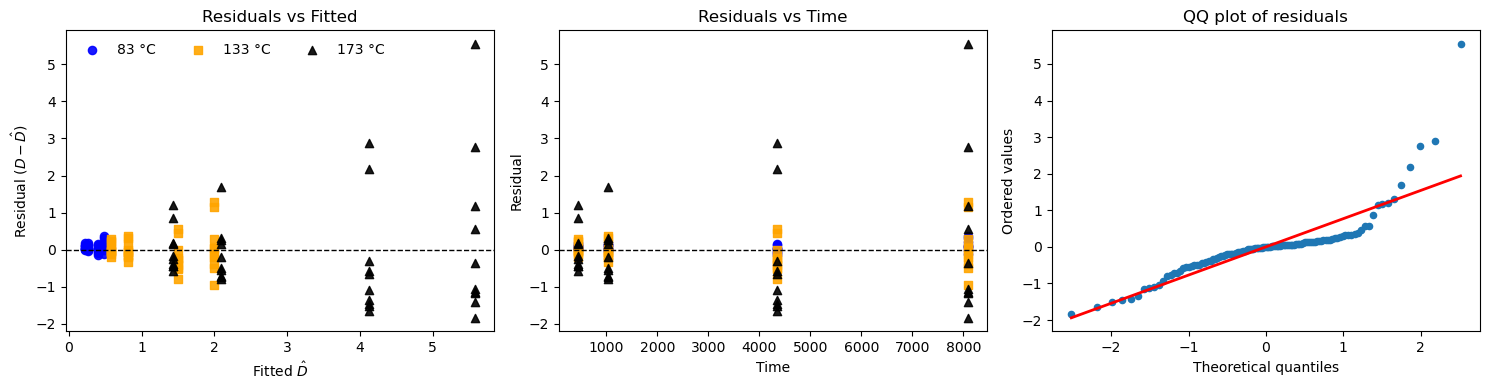

NotImplementedError: Bayesian not yet implemented in this class. Consider wrapping your PyMC/Stan model here and storing posterior draws.

In [14]:
import pandas as pd

df = pd.read_csv("Example_5.2_resistor_data.csv")

# --- Tidy (long) format for plotting ---
time_cols = ['h_452', 'h_1030', 'h_4341', 'h_8084']
time_map = {'h_452': 452, 'h_1030': 1030, 'h_4341': 4341, 'h_8084': 8084}

long = df.melt(
    id_vars=['Unit', 'Temperature_C'],
    value_vars=time_cols,
    var_name='time_label',
    value_name='pct_increase'
).dropna(subset=['pct_increase'])

long['hours'] = long['time_label'].map(time_map).astype(int)
t_time = long["hours"].to_numpy(float)
T_acc_C = long["Temperature_C"].to_numpy(float)
D_obs = long["pct_increase"].to_numpy(float)
T_degC = long["Temperature_C"].to_numpy(float)
unit = long["Unit"].to_numpy()
T_use = 50   # deg C


mle_fit = Fit_ADT_sqrt_Arrhenius(
    degradation=D_obs,
    stress=T_acc_C,
    time=t_time,
    unit = unit,
    stress_use=T_use,
    CI=0.50,
    method="Bayesian",
    # noise="additive",
    noise="multiplicative",
    show_data_plot=False,
    show_LSQ_diagnostics=True,
    show_noise_bounds=True,
    print_results=True)